# YOLOv5 Retail Item Detection Notebook

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
!git clone https://github.com/jkassis/Retail-Store-Item-Detection-using-YOLOv5
!mv Retail-Store-Item-Detection-using-YOLOv5 yolov5
!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets
from pydrive.drive import GoogleDrive

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Download Data

#### We first download the augmented and annotated image data from Roboflow website. Dont forget to enter the data download key link below which has unique key restricted for each user

In [ ]:
# Export code snippet and paste here
%cd /content
robo_flow_data_download_key = "ENTER YOUR DATA DOWNLOAD LINK HERE IN QUOTES"
# !curl -L robo_flow_data_download_key > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.ai/ds/dNpgZfRlr4?key=cteun9wN2k" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


#### We can see in this cell, that class to be predicted is 1 i.e. retail object, as defined in the .yaml file

In [4]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['object']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.


In [5]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
%cd /content/
##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('yolov5/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

/content
custom model config written!


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 300 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --nosave --cache

#### We save our yolov5 trained weights as in .pt file in Google Drive

In [ ]:
%cp /content/yolov5/weights/last_yolov5s_results.pt /content/gdrive/My\ Drive

Mounted at /content/gdrive


# Evaluate Custom YOLOv5 Detector Performance

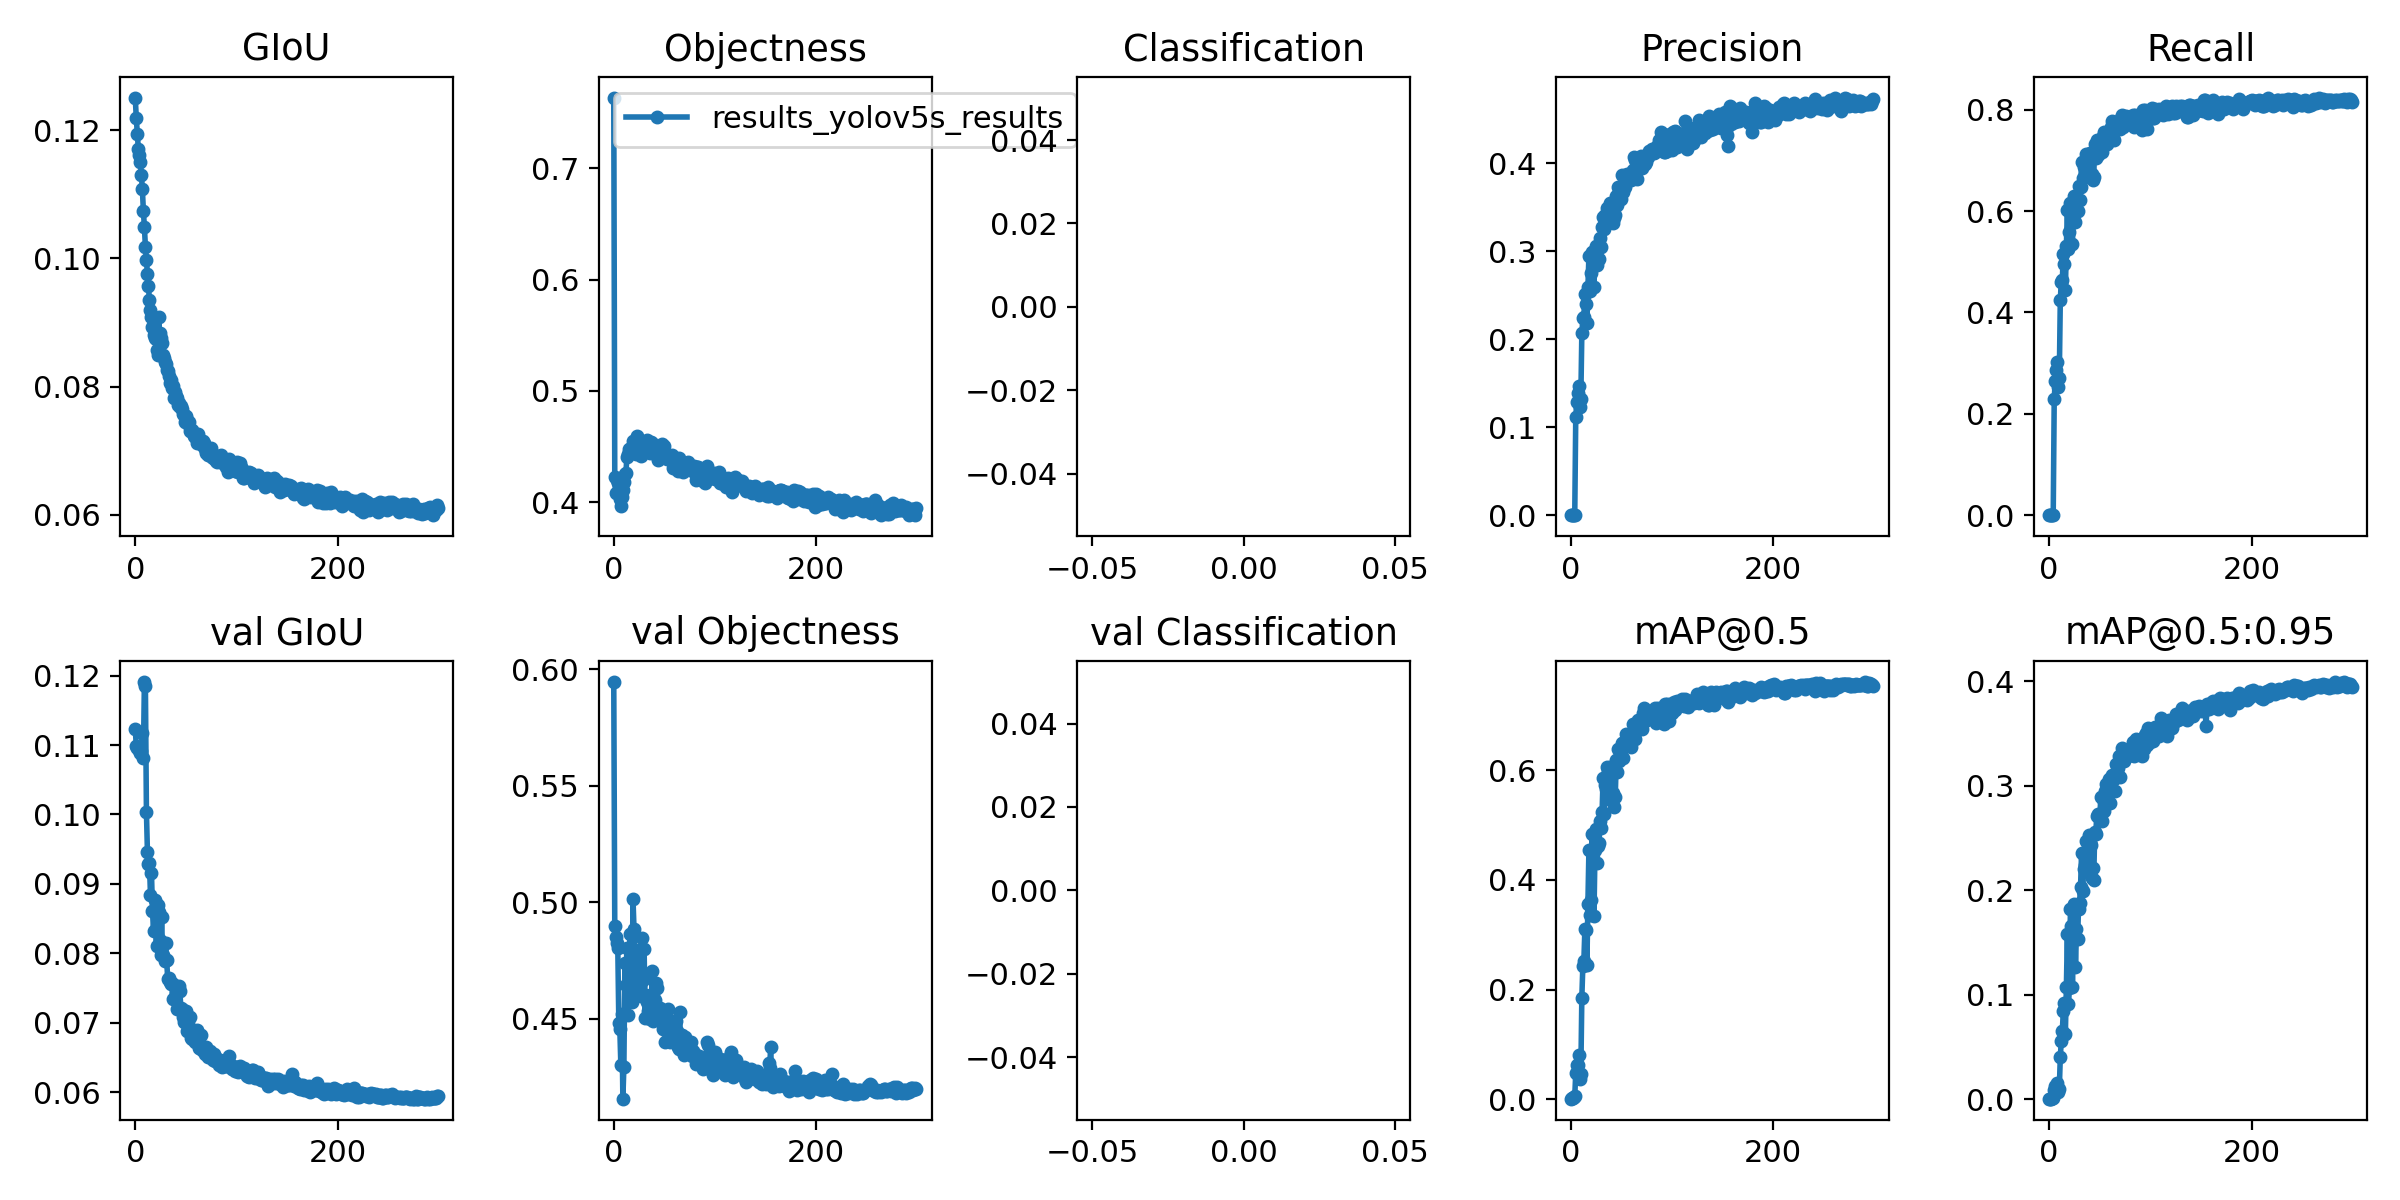

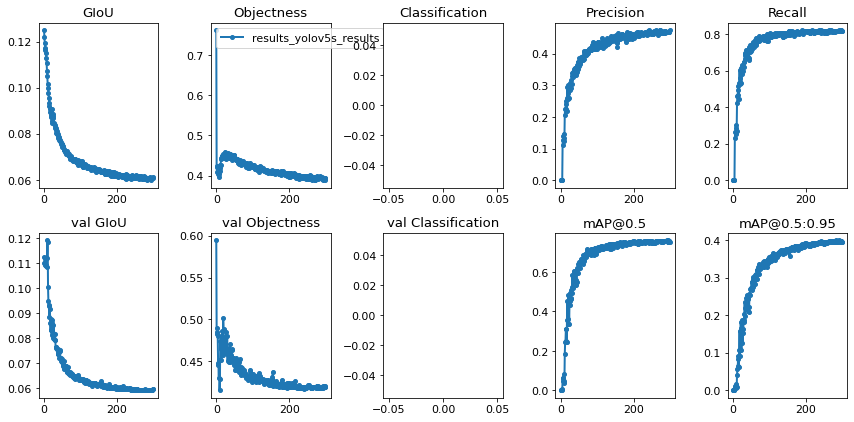

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.utils import plot_results; plot_results()  # plot results.txt as results.png
Image(filename='./results.png', width=1000)  # view results.png

### This is the training set image batch with known annotations

GROUND TRUTH AUGMENTED TRAINING DATA:


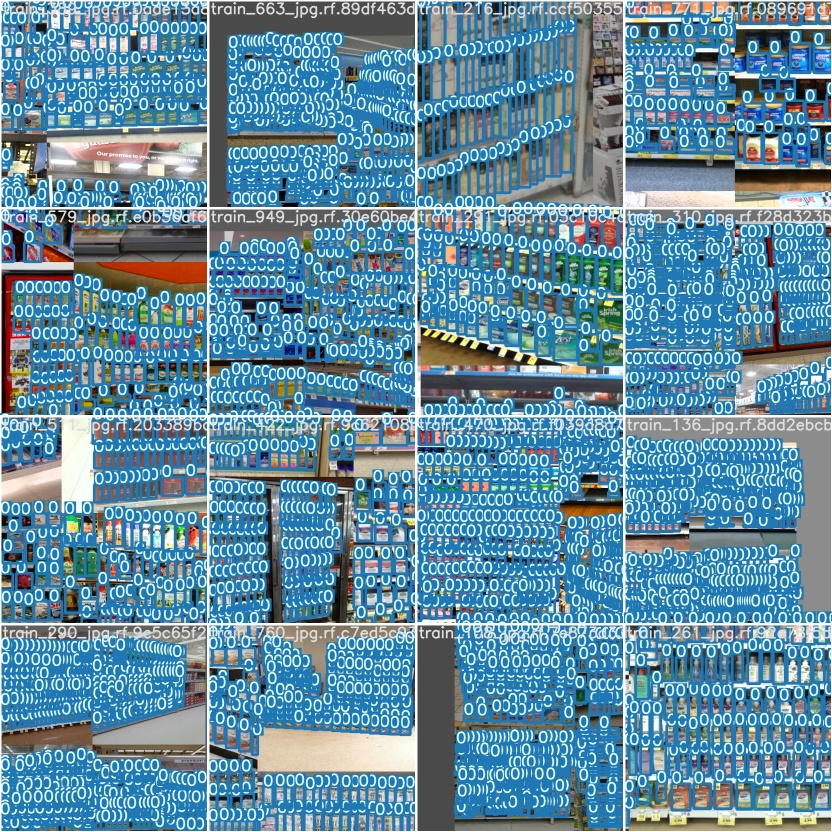

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./train_batch2.jpg', width=900)

## Predictions

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder in Colab Pro
%ls weights/

last_yolov5s_results.pt


In [ ]:

%cd /content/yolov5/
!python detect.py --weights weights/last_yolov5s_results.pt --img 416 --conf 0.4 --source ../test/images


### Bounding boxes predicted by our trained YOLOv5 model on test set images

In [ ]:
#display inference on ALL test images
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

[link text](https://)# Export Trained Weights for Future Inference


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Save the Model

#### Copy the results to Google Drive

In [ ]:
%cp /content/yolov5/weights/last_yolov5s_results.pt /content/gdrive/My\ Drive

# Retrieve the Model

#### Copy the results back to Runtime

In [7]:
%mkdir -p /content/yolov5/weights
%cp /content/gdrive/My\ Drive/last_yolov5s_results.pt /content/yolov5/weights/last_yolov5s_results.pt

# Convert to ONNX

In [29]:
%cd /content/yolov5
!pip install onnx>=1.7.0 # for ONNX export
!pip install onnx-simplifier
!pip install coremltools==4.0 # for CoreML export
!export PYTHONPATH="$PWD" && python models/export.py --weights /content/yolov5/weights/last_yolov5s_results.pt --img 416 --batch 1 # export at 640x640 with batch size 1


/content/yolov5
Namespace(batch_size=1, img_size=[416, 416], weights='/content/yolov5/weights/last_yolov5s_results.pt')
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)

starting export with onnx 1.10.2...
simplifying with onnx-simplifier 0.3.6...
export success, saved as /content/yolov5/weights/last_yolov5s_results.onnx
run --dynamic ONNX model inference with: 'python detect.py --weights /content/yolov5/weights/last_yolov5s_results.onnx'

Export complete. Visualize with https://github.com/lutzroeder/netron.


In [ ]:
"""Exports a YOLOv5 *.pt model to ONNX and TorchScript formats

Usage:
    $ export PYTHONPATH="$PWD" && python models/export.py --weights ./weights/yolov5s.pt --img 640 --batch 1
"""

import argparse

from models.common import *
from utils import google_utils

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default='./yolov5s.pt', help='weights path')
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='image size')
    parser.add_argument('--batch-size', type=int, default=1, help='batch size')
    opt = parser.parse_args()
    opt.img_size *= 2 if len(opt.img_size) == 1 else 1  # expand
    print(opt)

    # Input
    img = torch.zeros((opt.batch_size, 3, *opt.img_size))  # image size(1,3,320,192) iDetection

    # Load PyTorch model
    google_utils.attempt_download(opt.weights)
    model = torch.load(opt.weights, map_location=torch.device('cpu'))['model'].float()
    model.eval()
    model.model[-1].export = True  # set Detect() layer export=True
    y = model(img)  # dry run


    # YOLOv5 ONNX export
    try:
        import onnx

        print(f'\nstarting export with onnx {onnx.__version__}...')
        f = opt.weights.replace('.pt', '.onnx')  # filename

        torch.onnx.export(model, img, f, verbose=False, opset_version=12,
                          training=torch.onnx.TrainingMode.EVAL,
                          do_constant_folding=True,
                          input_names=['images'],
                          output_names=['output'],
                          dynamic_axes={'images': {0: 'batch', 2: 'height', 3: 'width'},  # shape(1,3,640,640)
                                        'output': {0: 'batch', 1: 'anchors'}  # shape(1,25200,85)
                                        })

        # Checks
        model_onnx = onnx.load(f)  # load onnx model
        onnx.checker.check_model(model_onnx)  # check onnx model
        # LOGGER.info(onnx.helper.printable_graph(model_onnx.graph))  # print

        # Simplify
        try:
            import onnxsim

            print(f'simplifying with onnx-simplifier {onnxsim.__version__}...')
            model_onnx, check = onnxsim.simplify(
                model_onnx,
                dynamic_input_shape=True,
                input_shapes={'images': list(img.shape)} if True else None)
            assert check, 'assert check failed'
            onnx.save(model_onnx, f)
        except Exception as e:
            print(f'simplifier failure: {e}')
        print(f'export success, saved as {f}')
        print(f"run --dynamic ONNX model inference with: 'python detect.py --weights {f}'")
    except Exception as e:
        print(f'export failure: {e}')



    # Finish
    print('\nExport complete. Visualize with https://github.com/lutzroeder/netron.')

In [9]:
%cp /content/yolov5/weights/last_yolov5s_results.onnx /content/gdrive/My\ Drive/last_yolov5s_results.onnx 

# Convert to Tensorflow

See this...
https://www.codeproject.com/Articles/5293077/Converting-YOLOv5-PyTorch-Model-Weights-to-TensorF

In [ ]:
!rm -rf /content/yolov5/weights/last_yolov5s_results.tf
!pip install tensorflow-addons
!pip install onnx-tf
!pip install tensorflow==2.6.0

import tensorflow_addons as tfa
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
print(tf.__version__)

base_model = onnx.load('/content/yolov5/weights/last_yolov5s_results.onnx')
to_tf = prepare(base_model)
to_tf.export_graph("/content/yolov5/weights/last_yolov5s_results.tf")



     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 4.0 MB 63.5 MB/s 
     |████████████████████████████████| 463 kB 54.8 MB/s 
     |████████████████████████████████| 14.8 MB 60.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.

2.3.0
INFO:tensorflow:Assets written to: /content/yolov5/weights/last_yolov5s_results.tf/assets


INFO:tensorflow:Assets written to: /content/yolov5/weights/last_yolov5s_results.tf/assets


### Convert to TFLite

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model('/content/yolov5/weights/last_yolov5s_results.tf')
#converter.experimental_new_converter = False
tflite_model = converter.convert() #just FYI: this step could go wrong and your notebook instance could crash.
open("/content/yolov5/weights/last_yolov5s_results.tflite", "wb").write(tflite_model)
!echo Done


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: images


INFO:tensorflow:Tensor's key in saved_model's tensor_map: images


INFO:tensorflow: tensor name: serving_default_images:0, shape: (1, 3, 416, 416), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_images:0, shape: (1, 3, 416, 416), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 386


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 386


INFO:tensorflow: tensor name: StatefulPartitionedCall:1, shape: (1, 3, 13, 13, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:1, shape: (1, 3, 13, 13, 6), type: DT_FLOAT


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 367


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 367


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, 3, 26, 26, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, 3, 26, 26, 6), type: DT_FLOAT


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: StatefulPartitionedCall:2, shape: (1, 3, 52, 52, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:2, shape: (1, 3, 52, 52, 6), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: images


INFO:tensorflow:Tensor's key in saved_model's tensor_map: images


INFO:tensorflow: tensor name: serving_default_images:0, shape: (1, 3, 416, 416), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_images:0, shape: (1, 3, 416, 416), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: StatefulPartitionedCall:2, shape: (1, 3, 52, 52, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:2, shape: (1, 3, 52, 52, 6), type: DT_FLOAT


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 367


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 367


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, 3, 26, 26, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, 3, 26, 26, 6), type: DT_FLOAT


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 386


INFO:tensorflow:Tensor's key in saved_model's tensor_map: 386


INFO:tensorflow: tensor name: StatefulPartitionedCall:1, shape: (1, 3, 13, 13, 6), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:1, shape: (1, 3, 13, 13, 6), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables


INFO:tensorflow:Restoring parameters from /content/yolov5/weights/last_yolov5s_results.tf/variables/variables
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [ ]:
%cd /content/yolov5/
!python detect.py --weights weights/last_yolov5s_results.tflite --img 416 --conf 0.4 --source ../test/image

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', fourcc='mp4v', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='../test/image', view_img=False, weights='weights/last_yolov5s_results.tflite')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   213  100   213    0     0    696      0 --:--:-- --:--:-- --:--:--   696
Traceback (most recent call last):
  File "detect.py", line 159, in <module>
    detect()
  File "detect.py", line 23, in detect
    google_utils.attempt_download(weights)
  File "/content/yolov5/utils/google_utils.py", line 36, in attempt_download
    raise Exception(msg)
Exception: weights/last_yolov5s_results.tflite missing, try downloading from https://drive.google.com/drive/folders/1Drs